In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'C:\Users\MR068144\Downloads\Python Scripts'
# importing required packages
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 

In [18]:
Years = range(2005,2017)
SegList = [
    {'Name':'HSIP201204001','Address':["41.439690, -90.805635","41.437567, -90.726870"],'MapExtent':500},
] 
IntList = [
    {'Name':'HSIP201204002','Address':"Keller Drive and Temple Avenue",'MapExtent':500},
]

Project_DIR = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO12\HSIP_TrackingTool\HSIPTrackingGIS'
Project_GDB = Project_DIR + '\\HSIPGISFiles.gdb'

DirPath = r'C:\Users\mr068144\Downloads\HSIP_TrackingTool'
MXD = os.path.join(DirPath,'HSIPReview_Streets.mxd')

IRISPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\5.0_Roadway_Layer\IRIS'
Intersections = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\6.0_Intersection_Layer\Intersection2014.mdb\Intersection2014_364596_CleanedUp'
IRIS_Route = {y:os.path.join(IRISPath,'HWY'+str(y)+'_route.shp') for y in Years}
IRIS_Table = {y:os.path.join(IRISPath,'HWY'+str(y)+'_table.dbf') for y in Years}
CrashData = {y:os.path.abspath('C:\Users\mr068144\Downloads\IL Crash Data\\' + str(y) + '\\AggregateFiles' +str(y)+ '.mdb'
                         '\\CrashExtract_' + str(y) + '_GIS') for y in Years}
WGS1984   = arcpy.SpatialReference(4326)
NAD1983IL = arcpy.SpatialReference(102672)

In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

In [3]:
def AdjustExtend(ext,distance):
    ext.XMax += distance
    ext.XMin -= distance
    ext.YMax += distance
    ext.YMin -= distance   
    return(ext)
def AddFCtoDataFrame(DF,FC):
    LayerName = os.path.basename(FC)
    arcpy.Delete_management(LayerName)
    arcpy.MakeFeatureLayer_management(in_features=FC,out_layer=LayerName)
    layer = arcpy.mapping.Layer(LayerName)
    arcpy.mapping.AddLayer(DF,layer,'AUTO_ARRANGE')
    return(layer)

Keller Drive and Temple Avenue,-88.5588128,39.1275096,2752710.50966,900114.09652,OK


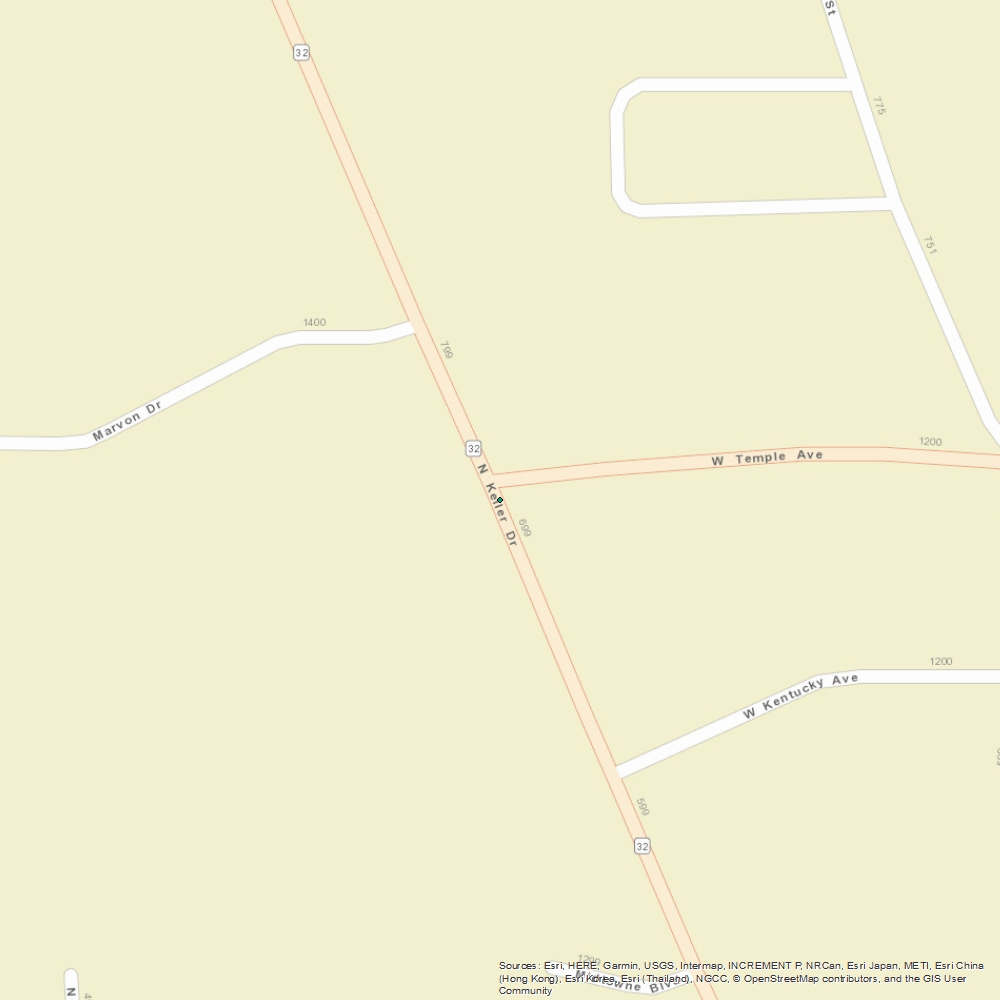

ExecuteError: Failed to execute. Parameters are not valid.
ERROR 000725: Output Dataset: Dataset \\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO12\HSIP_TrackingTool\HSIPTrackingGIS\HSIPGISFiles.gdb\HSIP_Int_Geo already exists.
Failed to execute (Merge).


In [35]:
# Geocode Int
IntFCList = []
for intx in IntList:
    IntFC = os.path.join(Project_GDB,intx['Name'])
    arcpy.Delete_management(IntFC)
    arcpy.CreateFeatureclass_management(out_path=Project_GDB,out_name=intx['Name'],geometry_type='POINT',spatial_reference=NAD1983IL)
    arcpy.AddField_management(IntFC,'Address','TEXT')
    arcpy.AddField_management(IntFC,'HSIP_ID','LONG')
    IC = arcpy.InsertCursor(IntFC)
    r = IC.newRow()
    r.setValue('HSIP_ID',intx['Name'][4:])
    r.setValue('Address',intx['Address'])
    IC.insertRow(r)
    del IC,r
    hsmpy.common.AddPointFromAddress(Input=IntFC,AddressField='Address')
    IntFCList.append(IntFC)
    mxd = arcpy.mapping.MapDocument(MXD)
    df = arcpy.mapping.ListDataFrames(mxd)[0]
    SitesLayer = AddFCtoDataFrame(DF=df,FC=IntFC)
    ext = SitesLayer.getExtent()  
    df.extent = AdjustExtend(ext,intx['MapExtent'])
    ImageName = intx['Name'] + '_Map' + '.jpg'
    arcpy.mapping.ExportToJPEG(mxd, os.path.join(DirPath, ImageName), df,
                           df_export_width=1000,
                           df_export_height=1000,
                           world_file=True)
    display(Image(os.path.join(DirPath, ImageName)))
Int_Geo = hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_GDB,'HSIP_Int'),appendix='Geo',Extension='')
arcpy.Merge_management(inputs=IntFCList,output=Int_Geo)
for intx in IntFCList:
    arcpy.Delete_management(intx)
hsmpy.common.AttributeTabletoDF(Int_Geo)

In [ ]:
#Geocode Seg
SegFCList = []
for seg in SegList:
    SegFC = os.path.join(Project_GDB,seg['Name'])
    arcpy.Delete_management(SegFC)
    res = hsmpy.common.AddSegFromAddresses([seg['Address']],IRIS_Route[2016],'INVENTORY',SegFC)
    arcpy.AddField_management(SegFC,'HSIP_ID','LONG')
    arcpy.CalculateField_management(SegFC,'HSIP_ID',seg['Name'][4:])
    SegFCList.append(SegFC)
    mxd = arcpy.mapping.MapDocument(MXD)
    df = arcpy.mapping.ListDataFrames(mxd)[0]
    SitesLayer = AddFCtoDataFrame(DF=df,FC=SegFC)
    ext = SitesLayer.getExtent()  
    df.extent = AdjustExtend(ext,seg['MapExtent'])
    ImageName = seg['Name'] + '_Map' + '.jpg'
    arcpy.mapping.ExportToJPEG(mxd, os.path.join(DirPath, ImageName), df,
                           df_export_width=1000,
                           df_export_height=1000,
                           world_file=True)
    try:os.remove(os.path.join(DirPath,  seg['Name'] + '_Map.jgw'))
    except:pass
    display(Image(filename = os.path.join(DirPath, ImageName)))
Seg_Geo = hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_GDB,'HSIP_Seg'),appendix='Geo',Extension='')
arcpy.Merge_management(inputs=SegFCList,output=Seg_Geo)
for seg in SegFCList:
    arcpy.Delete_management(seg)
hsmpy.common.AttributeTabletoDF(Seg_Geo)